In [1]:
%load_ext autoreload

In [11]:
%autoreload 2

from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import h5py
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, wilcoxon
from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *
from UniversalUnconsciousness.power_analysis import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
cfg.params.low_pass = None
cfg.params.high_pass = None

cfg.params.stride = 15
cfg.params.window = 15

In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:
agent_data = get_agent_data(cfg, use_individiual_areas=False, verbose=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Only 1 valid windows could be found for section 'awake lever1' with times [-36.120676111111116, -26.045618333333337]


In [7]:
area = 'all'
# save_dir = "/orcd/data/ekmiller/001/eisenaj/UniversalUnconsciousness/power_analysis"
save_dir = "/scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/power_analysis"

# Freq correlations

In [8]:
top_percent = 0.1
doses = ['high']

power_info = {}
corr_power_info = {}
all_freq_powers = {}
for data_class, agent in tqdm(anesthetic_agent_list):
# for data_class, agent in tqdm([anesthetic_agent_list[1]]):
    delase_results = agent_data[(data_class, agent)]['delase_results']
    cfg.params.data_class = data_class
    agent_save_dir = os.path.join(save_dir, data_class, agent, area)
    power_info[(data_class, agent)] = {}
    corr_power_info[(data_class, agent)] = {}
    all_freq_powers[(data_class, agent)] = {}
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        power_info[(data_class, agent)][monkey] = {}
        corr_power_info[(data_class, agent)][monkey] = {}
        all_freq_powers[(data_class, agent)][monkey] = {}
        # for dose in agent_data[(data_class, agent)]['session_lists'][monkey]:
        for dose in doses:
            power_info[(data_class, agent)][monkey][dose] = {}
            corr_power_info[(data_class, agent)][monkey][dose] = {}
            all_freq_powers[(data_class, agent)][monkey][dose] = {}
            for session in agent_data[(data_class, agent)]['session_lists'][monkey][dose]:
                if not os.path.exists(os.path.join(agent_save_dir, f'{session}__top_percent_{top_percent}_power_analysis.pkl')):
                    # raise ValueError(f"Session {session} does not exist")
                    print(f"Session {session} does not exist, skipping")
                else:
                    ret_dict = pd.read_pickle(os.path.join(agent_save_dir, f'{session}__top_percent_{top_percent}_power_analysis.pkl'))
                    freq_powers = ret_dict['freq_powers']
                    all_freq_powers[(data_class, agent)][monkey][dose][session] = freq_powers
                    corr_power_info[(data_class, agent)][monkey][dose][session] = {band: pearsonr(delase_results[session][area].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()), freq_powers[band]).statistic for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']}
                    # corr_power_info[(data_class, agent)][monkey][dose][session] = {band: spearmanr(delase_results[session][area].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()), freq_powers[band]).statistic for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']}
                    freq_r2_scores = ret_dict['freq_r2_scores']
                    power_info[(data_class, agent)][monkey][dose][session] = freq_r2_scores


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
plot_info = {}
for data_class, agent in tqdm(anesthetic_agent_list):
    plot_info[(data_class, agent)] = {}
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        plot_info[(data_class, agent)][monkey] = {}
        # for dose in agent_data[(data_class, agent)]['session_lists'][monkey]:
        for dose in doses:
            plot_info[(data_class, agent)][monkey][dose] = {band: [] for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']}
            # for session in agent_data[(data_class, agent)]['session_lists'][monkey][dose]:
            for session in corr_power_info[(data_class, agent)][monkey][dose]:
                for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
                    # plot_info[(data_class, agent)][monkey][dose][band].append(power_info[(data_class, agent)][monkey][dose][session][band])
                    plot_info[(data_class, agent)][monkey][dose][band].append(corr_power_info[(data_class, agent)][monkey][dose][session][band])

  0%|          | 0/3 [00:00<?, ?it/s]

propofol Mary high delta: p-val = 0.001953125
propofol Mary high theta: p-val = 0.001953125
propofol Mary high alpha: p-val = 0.001953125
propofol Mary high beta: p-val = 0.001953125
propofol Mary high gamma: p-val = 0.001953125
propofol MrJones high delta: p-val = 0.0009765625
propofol MrJones high theta: p-val = 0.0009765625
propofol MrJones high alpha: p-val = 0.0009765625
propofol MrJones high beta: p-val = 0.0009765625
propofol MrJones high gamma: p-val = 0.0029296875
ketamine SPOCK high delta: p-val = 0.0078125
ketamine SPOCK high theta: p-val = 0.0078125
ketamine SPOCK high alpha: p-val = 0.0078125
ketamine SPOCK high beta: p-val = 0.0078125
ketamine SPOCK high gamma: p-val = 0.0078125
ketamine PEDRI high delta: p-val = 0.0078125
ketamine PEDRI high theta: p-val = 0.0078125
ketamine PEDRI high alpha: p-val = 0.0234375
ketamine PEDRI high beta: p-val = 0.0390625
ketamine PEDRI high gamma: p-val = 0.0234375
dexmedetomidine SPOCK high delta: p-val = 0.0078125
dexmedetomidine SPOCK 

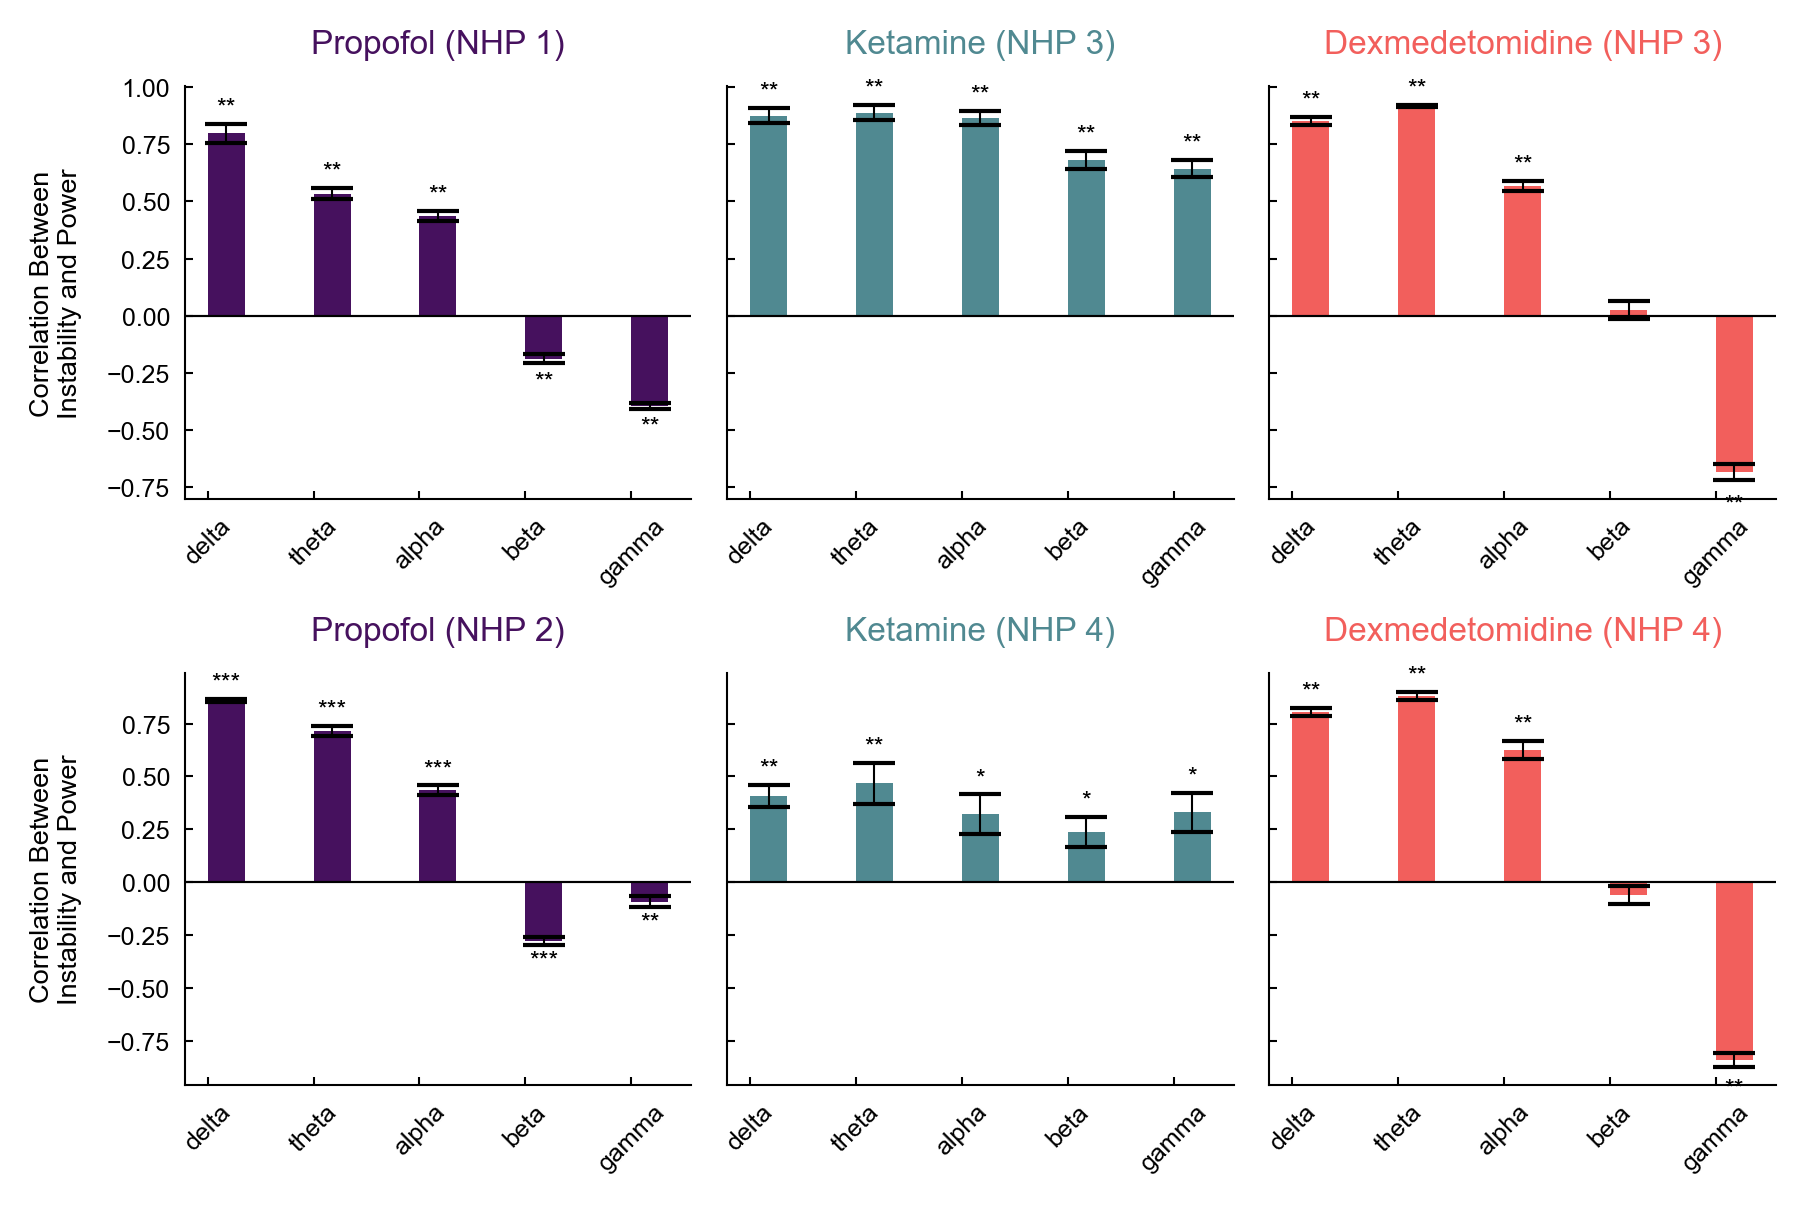

In [16]:

plot_power_analysis_grid(plot_info, anesthetic_agent_list, curve_colors, layout='nhp_rows', save_path=os.path.join(img_save_dir, 'power_analysis_grid.pdf'), figsize=(6, 4))

# Freq Power Means and Comparisons

In [8]:
top_percent = 0.1
doses = ['high']

mean_power_info = {}
for data_class, agent in tqdm(anesthetic_agent_list):
# for data_class, agent in tqdm([anesthetic_agent_list[1]]):
    delase_results = agent_data[(data_class, agent)]['delase_results']
    cfg.params.data_class = data_class
    agent_save_dir = os.path.join(save_dir, data_class, agent, area)
    mean_power_info[(data_class, agent)] = {}
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        mean_power_info[(data_class, agent)][monkey] = {}
        # for dose in agent_data[(data_class, agent)]['session_lists'][monkey]:
        for dose in doses:
            mean_power_info[(data_class, agent)][monkey][dose] = {}
            for session in agent_data[(data_class, agent)]['session_lists'][monkey][dose]:
                if not os.path.exists(os.path.join(agent_save_dir, f'{session}__top_percent_{top_percent}_power_analysis.pkl')):
                    # raise ValueError(f"Session {session} does not exist")
                    print(f"Session {session} does not exist, skipping")
                else:
                    ret_dict = pd.read_pickle(os.path.join(agent_save_dir, f'{session}__top_percent_{top_percent}_power_analysis.pkl'))
                    freq_powers = ret_dict['freq_powers']

                    section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class, section_info_type='plot')
                    window_times = delase_results[session][area].window_start # s
                    window_times_min =(window_times - infusion_start) / 60
                    awake_bool = (window_times_min > section_info[0][1][0]) & (window_times_min < section_info[0][1][1])
                    anesthesia_bool = (window_times_min > section_info[2][1][0]) & (window_times_min < section_info[2][1][1])
                    emergence_bool = (window_times_min > section_info[4][1][0]) & (window_times_min < section_info[4][1][1])

                    mean_power_info[(data_class, agent)][monkey][dose][session] = {}
                    for band in ret_dict['freq_powers']:
                        awake_mean, anesthesia_mean, emergence_mean = ret_dict['freq_powers'][band][awake_bool].mean(), ret_dict['freq_powers'][band][anesthesia_bool].mean(), ret_dict['freq_powers'][band][emergence_bool].mean()

                        mean_power_info[(data_class, agent)][monkey][dose][session][band] = {
                            'awake_mean': awake_mean,
                            'anesthesia_mean': anesthesia_mean,
                            'emergence_mean': emergence_mean
                        }

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

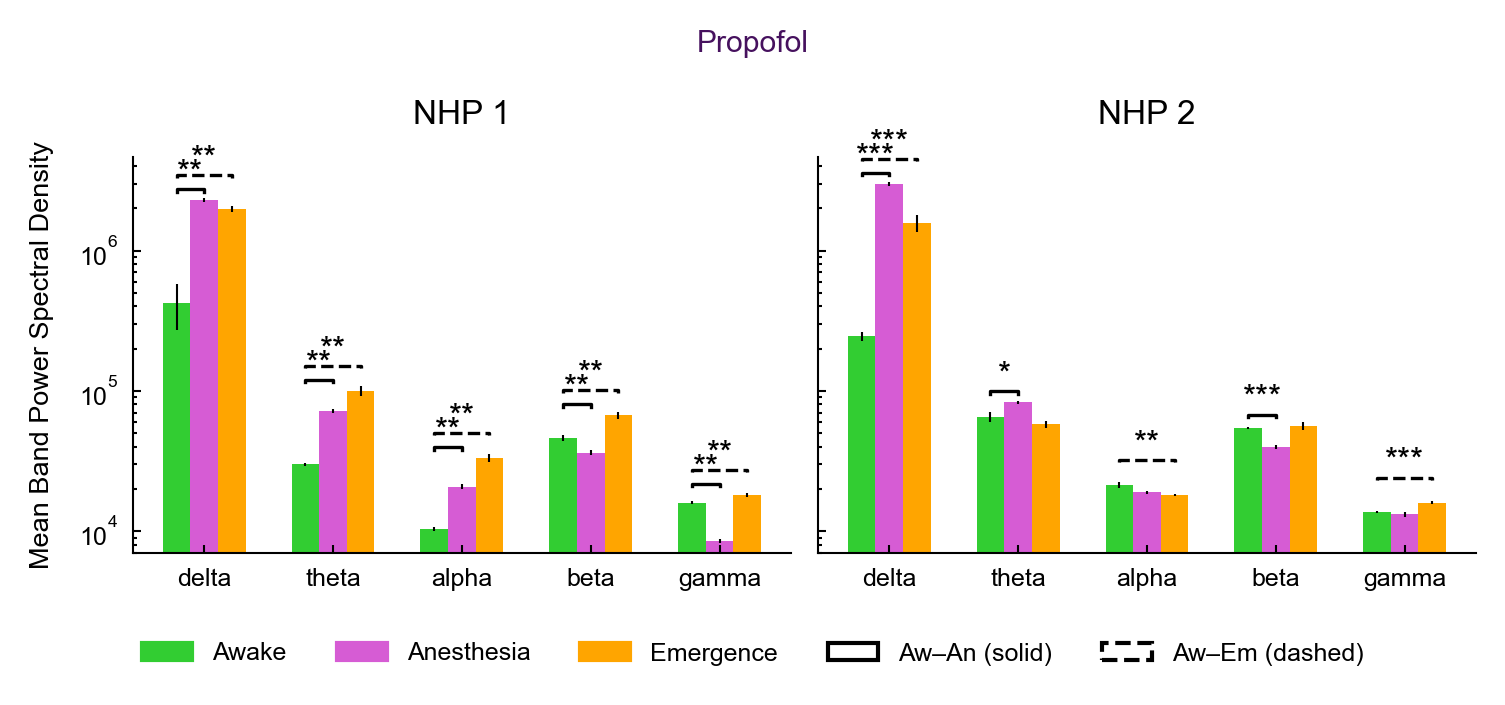

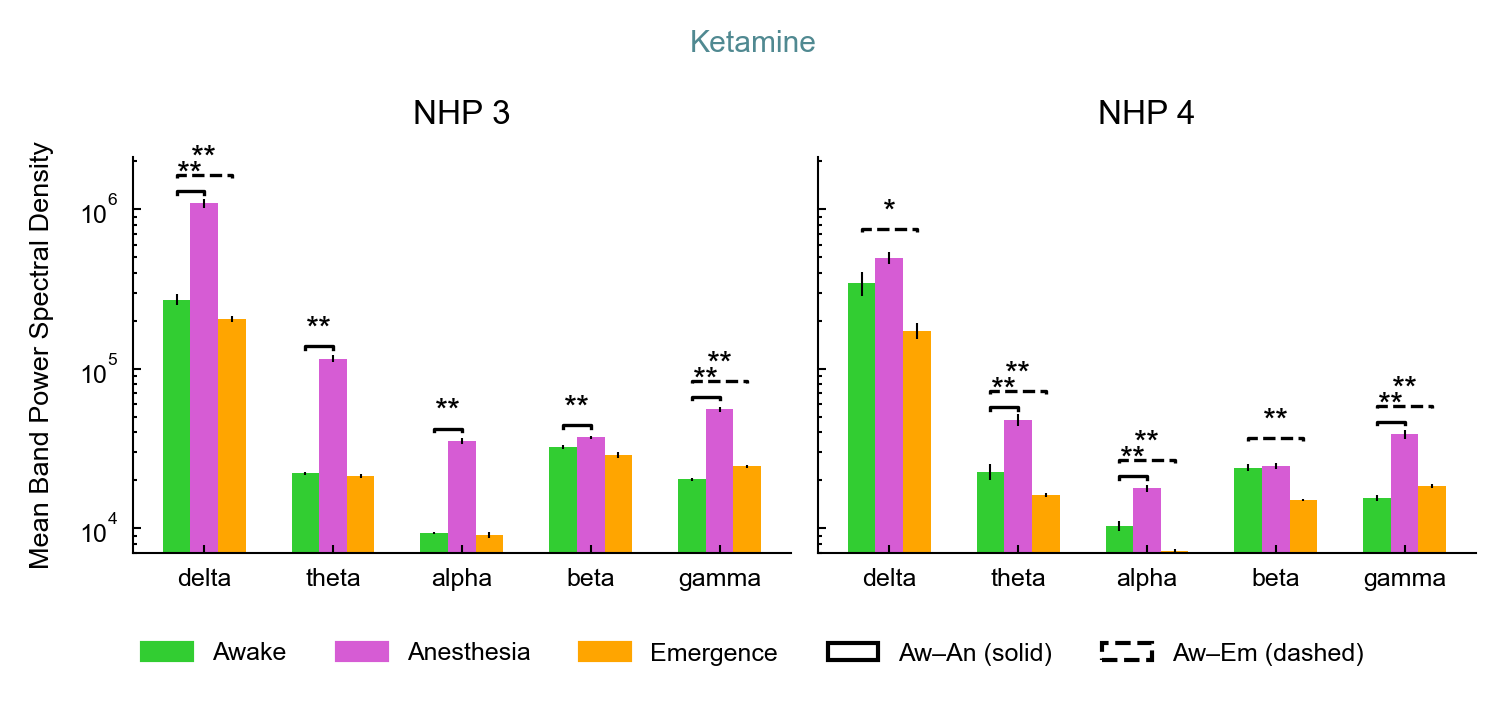

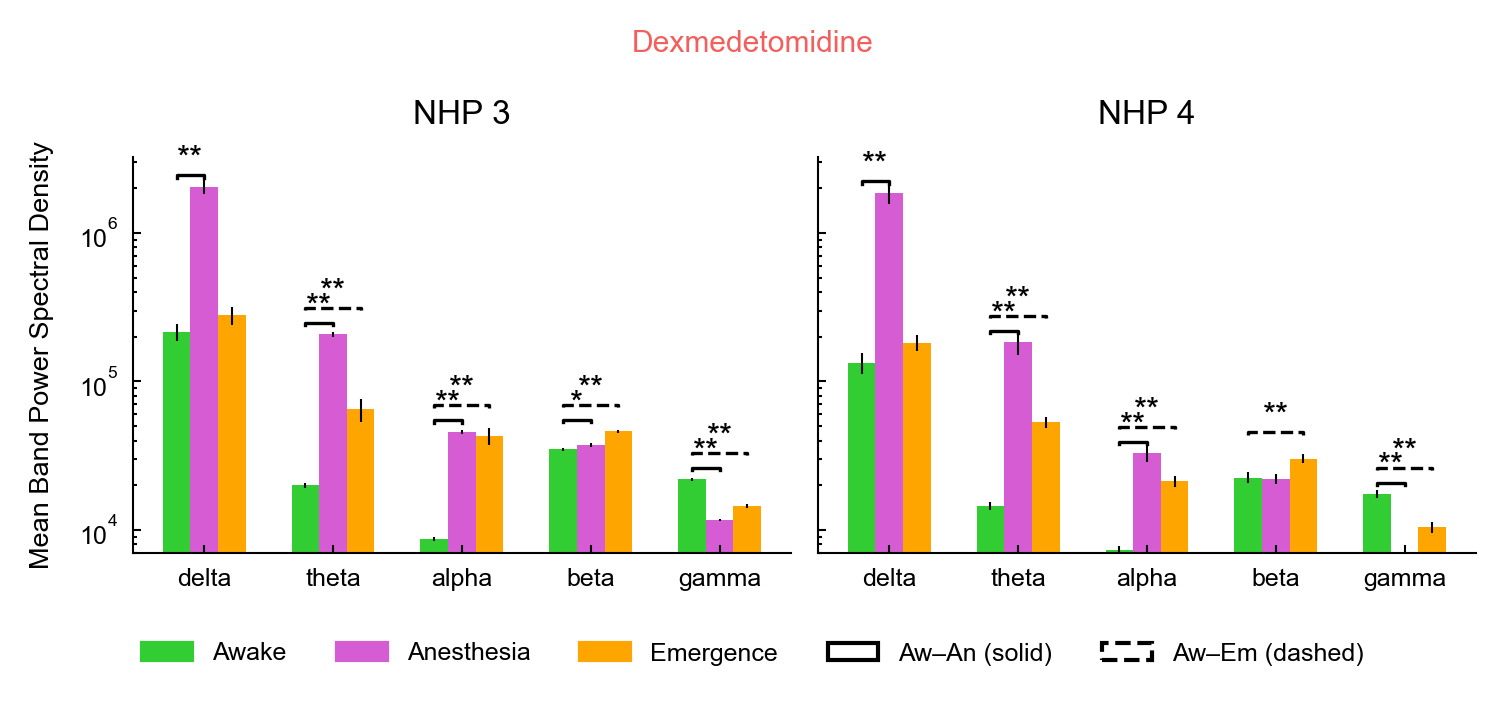

In [ ]:
for data_class, agent in tqdm(anesthetic_agent_list):
    band_means = {}
    monkeys = list(mean_power_info[(data_class, agent)].keys())
    for monkey in monkeys:
        band_means[monkey] = {}
        for dose in ['high']:
            band_means[monkey][dose] = {}
            session_0 = list(mean_power_info[(data_class, agent)][monkey][dose].keys())[0]
            bands = list(mean_power_info[(data_class, agent)][monkey][dose][session_0].keys())
            for band in bands:
                band_means[monkey][dose][band] = {
                    'awake': [],
                    'anesthesia': [],
                    'emergence': []
                }
            
            for session in mean_power_info[(data_class, agent)][monkey][dose]:
                for band in bands:
                    band_means[monkey][dose][band]['awake'].append(mean_power_info[(data_class, agent)][monkey][dose][session][band]['awake_mean'])
                    band_means[monkey][dose][band]['anesthesia'].append(mean_power_info[(data_class, agent)][monkey][dose][session][band]['anesthesia_mean'])
                    band_means[monkey][dose][band]['emergence'].append(mean_power_info[(data_class, agent)][monkey][dose][session][band]['emergence_mean'])

    import matplotlib.patches as mpatches


    # ------------------------------------------------------------------
    # BASIC SETTINGS
    # ------------------------------------------------------------------
    # bands       = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    # monkeys     = ['SPOCK', 'PEDRI']                 # order of sub-plots
    x_centers   = np.arange(len(bands)) * 2.8        # spacing between band clusters
    bar_width   = 0.6                                # width of a single bar
    alpha_thr   = 0.05                               # significance threshold

    # colours – assume section_colors dict already exists
    awake_color, anesthesia_color, emergence_color = (
        section_colors['Awake'],
        section_colors['Anesthesia'],
        section_colors['Emergence'],
    )

    # ------------------------------------------------------------------
    # HELPER FUNCTIONS
    # ------------------------------------------------------------------
    def p_to_stars(p):
        """Convert p-value to significance stars; returns '' when p ≥ alpha_thr."""
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < alpha_thr:
            return '*'
        return ''


    def draw_bracket(ax, x1, x2, y, label, ls):
        """Draw a square bracket with optional label."""
        if not label:               # skip drawing entirely if label is empty
            return
        h = y * 0.04                # tick height (4 % of y)
        ax.plot([x1, x1, x2, x2],
                [y,  y + h,  y + h, y],
                color='black', lw=0.8, linestyle=ls)
        ax.text((x1 + x2) / 2, y + h,
                label, ha='center', va='bottom', fontsize=8)


    # ------------------------------------------------------------------
    # SUB-PLOT FUNCTION
    # ------------------------------------------------------------------
    def build_subplot(ax, monkey, title):
        for i, band in enumerate(bands):
            # ----------------------------------------------------------
            # data
            # ----------------------------------------------------------
            awake       = np.array(band_means[monkey]['high'][band]['awake'])
            unconscious = np.array(band_means[monkey]['high'][band]['anesthesia'])
            emergence   = np.array(band_means[monkey]['high'][band]['emergence'])

            means = [awake.mean(), unconscious.mean(), emergence.mean()]
            sems  = [awake.std(ddof=1) / np.sqrt(len(awake)),
                    unconscious.std(ddof=1) / np.sqrt(len(unconscious)),
                    emergence.std(ddof=1) / np.sqrt(len(emergence))]

            # ----------------------------------------------------------
            # bars
            # ----------------------------------------------------------
            xc                     = x_centers[i]
            x_awake, x_unc, x_eme  = xc - bar_width, xc, xc + bar_width

            ax.bar(x_awake, means[0], bar_width, color=awake_color,      yerr=sems[0],
                label='Awake'       if i == 0 else '')
            ax.bar(x_unc,  means[1], bar_width, color=anesthesia_color, yerr=sems[1],
                label='Anesthesia' if i == 0 else '')
            ax.bar(x_eme,  means[2], bar_width, color=emergence_color,  yerr=sems[2],
                label='Emergence'  if i == 0 else '')

            # ----------------------------------------------------------
            # statistics & (conditional) brackets
            # ----------------------------------------------------------
            p_aw_unc = wilcoxon(awake, unconscious).pvalue
            p_aw_eme = wilcoxon(awake, emergence).pvalue

            label_aw_unc = p_to_stars(p_aw_unc)   # solid (lower) bracket
            label_aw_eme = p_to_stars(p_aw_eme)   # dashed (upper) bracket

            ymax  = max(means)
            y_low = ymax * 1.15                   # Awake–Anesthesia
            y_hi  = ymax * 1.45                   # Awake–Emergence

            draw_bracket(ax, x_awake, x_unc, y_low, label_aw_unc, ls='-')
            draw_bracket(ax, x_awake, x_eme, y_hi,  label_aw_eme, ls='--')

        # --------------------------------------------------------------
        # cosmetics
        # --------------------------------------------------------------
        ax.set_title(title)
        ax.set_xticks(x_centers)
        ax.set_xticklabels(bands)
        if monkey == 'SPOCK' or monkey == 'Mary':
            ax.set_ylabel('Mean Band Power Spectral Density')
        ax.set_yscale('log')
        ax.set_ylim(bottom=7000)                   # maintain previous lower bound


    # ------------------------------------------------------------------
    # BUILD FIGURE
    # ------------------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2), sharey=True)

    if agent == 'propofol':
        nhp_names = ['NHP 1', 'NHP 2']
    else:
        nhp_names = ['NHP 3', 'NHP 4']

    build_subplot(ax1, monkeys[0], nhp_names[0])
    build_subplot(ax2, monkeys[1], nhp_names[1])

    plt.suptitle(f'{agent.capitalize()}', c=cfg.plotting.curve_colors[agent])

    # unified legend
    handles = [
        mpatches.Patch(color=awake_color,       label='Awake'),
        mpatches.Patch(color=anesthesia_color,  label='Anesthesia'),
        mpatches.Patch(color=emergence_color,   label='Emergence'),
        mpatches.Patch(facecolor='white', edgecolor='black', linestyle='-',  label='Aw–An (solid)'),
        mpatches.Patch(facecolor='white', edgecolor='black', linestyle='--', label='Aw–Em (dashed)')
    ]
    fig.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, -0.06), ncol=5)

    plt.tight_layout()
    plt.savefig(os.path.join(cfg.plotting.img_save_dir, 'supp', f'{agent}_power-analysis_with_anesth.pdf'),
                bbox_inches='tight', transparent=True)
    plt.show()

In [12]:
area = 'all'
total_its = 0
for data_class, agent in tqdm(anesthetic_agent_list):
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        for session in agent_data[(data_class, agent)]['session_lists'][monkey]['high']:
            total_its += 1
print(f"Total sessions: {total_its}")
iterator = tqdm(total=total_its)

power_spectra = {}
for data_class, agent in anesthetic_agent_list:
    agent_save_dir = os.path.join(save_dir, data_class, agent, area)
    power_spectra[(data_class, agent)] = {}
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        power_spectra[(data_class, agent)][monkey] = {}
        for session in  agent_data[(data_class, agent)]['session_lists'][monkey]['high']:
            file_path = os.path.join(agent_save_dir, f'{session}__fft_analysis.pkl')
            if not os.path.exists(file_path):
                print(f"FFT analysis for {session} does not exist")
                raise ValueError("Stop here")
            else:
                ffts = pd.read_pickle(file_path)
                power_spectra[(data_class, agent)][monkey][session] = ffts
            iterator.update(1)
iterator.close()

  0%|          | 0/3 [00:00<?, ?it/s]

Total sessions: 53


  0%|          | 0/53 [00:00<?, ?it/s]

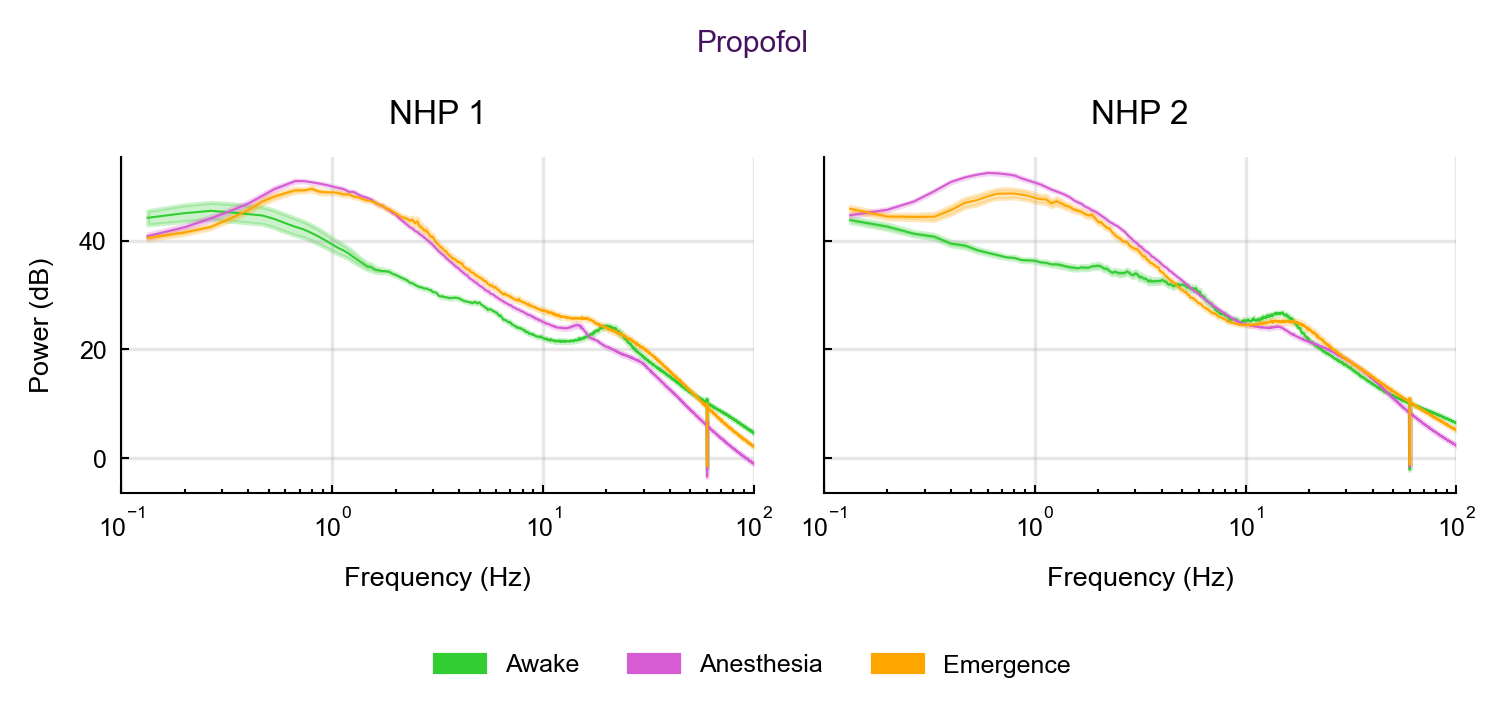

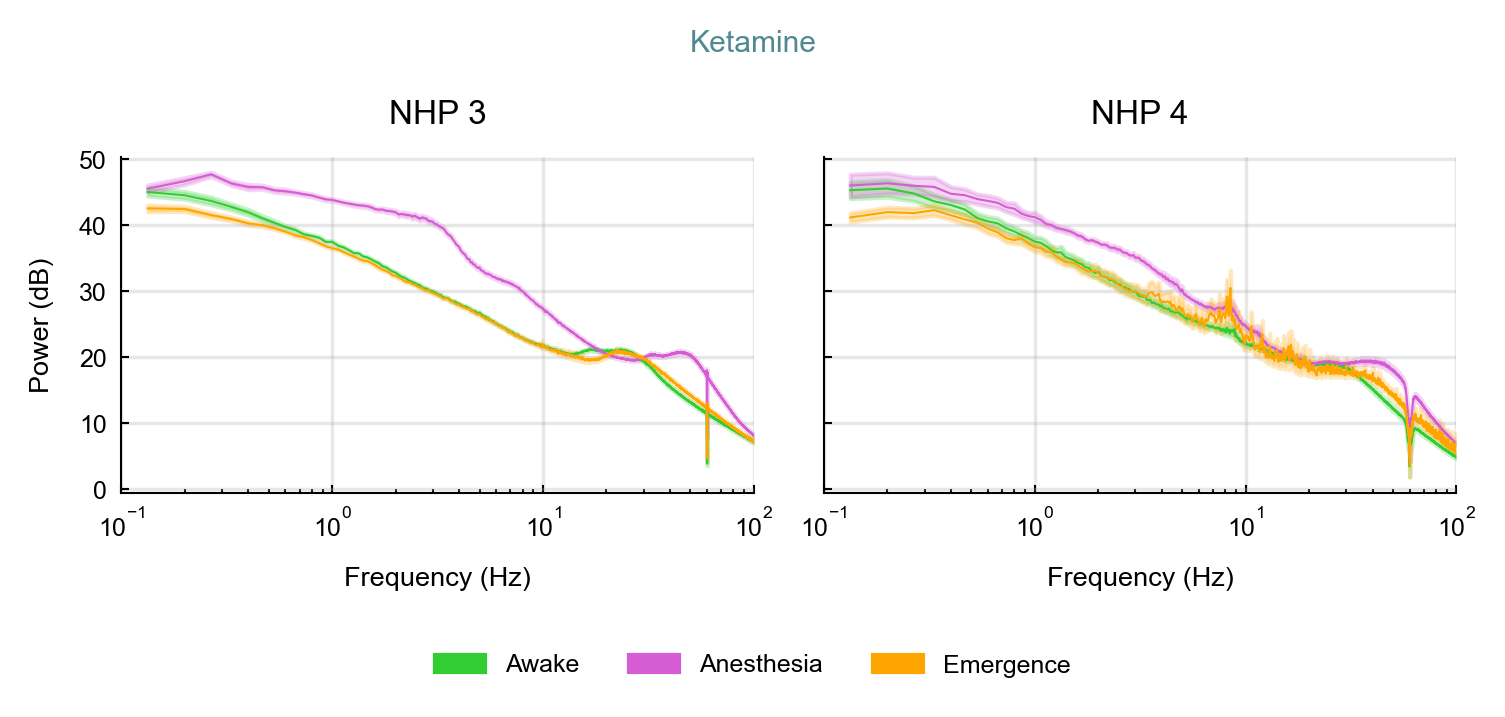

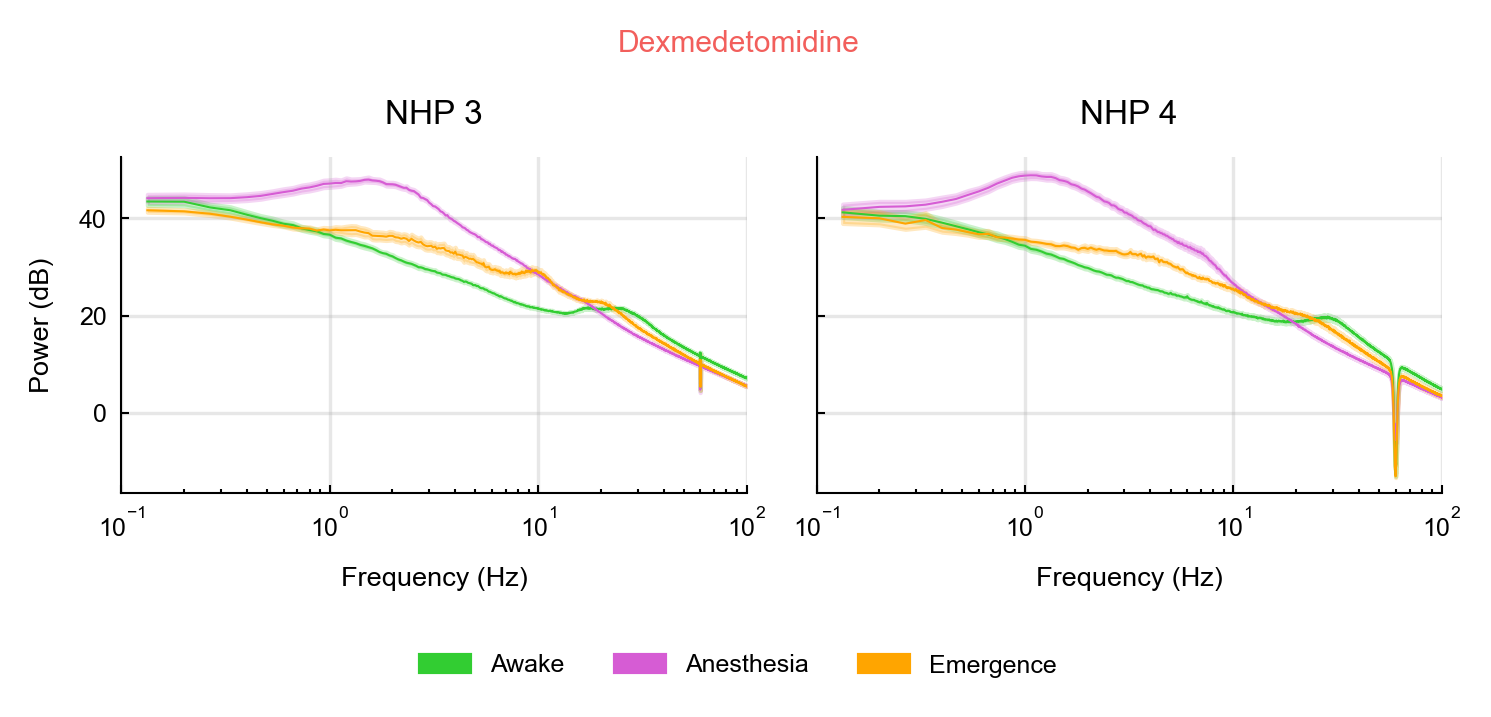

In [39]:
# ------------------------------------------------------------------
#  Power–spectrum plots (dB) – 3 figures, 2 sub-plots each
# ------------------------------------------------------------------
import matplotlib.patches as mpatches

min_freq, max_freq = 0.1, 100     # frequency window to display

for data_class, agent in anesthetic_agent_list:
    # ------------------------------------------------------------------
    #  basic prep
    # ------------------------------------------------------------------
    cfg.params.data_class = data_class                       # needed by get_section_info
    monkeys     = list(power_spectra[(data_class, agent)].keys())
    sample_sess = list(power_spectra[(data_class, agent)][monkeys[0]].keys())[0]
    _, _, section_colors, _ = get_section_info(
        sample_sess, cfg.params.all_data_dir,
        cfg.params.data_class, section_info_type='plot'
    )

    # colours
    awake_color, anesthesia_color, emergence_color = (
        section_colors['Awake'],
        section_colors['Anesthesia'],
        section_colors['Emergence'],
    )

    # ------------------------------------------------------------------
    #  helper
    # ------------------------------------------------------------------
    def build_subplot(ax, monkey, title):
        """Mean spectrum ± SEM (shaded) in dB."""
        # grab all sessions for this monkey
        sessions = power_spectra[(data_class, agent)][monkey]
        freqs    = sessions[next(iter(sessions))]['freqs']

        # stack spectra    (num_sessions  ×  num_freqs)
        awake_mat       = np.vstack([v['awake_power_spectrum']       for v in sessions.values()])
        anesthesia_mat  = np.vstack([v['anesthesia_power_spectrum']  for v in sessions.values()])
        emergence_mat   = np.vstack([v['emergence_power_spectrum']   for v in sessions.values()])

        # convert to dB
        def lin2db(x): return 10 * np.log10(x)

        awake_mean_lin      = awake_mat.mean(axis=0)
        anesthesia_mean_lin = anesthesia_mat.mean(axis=0)
        emergence_mean_lin  = emergence_mat.mean(axis=0)

        awake_sem_lin       = awake_mat.std(axis=0, ddof=1) / np.sqrt(awake_mat.shape[0])
        anesthesia_sem_lin  = anesthesia_mat.std(axis=0, ddof=1) / np.sqrt(anesthesia_mat.shape[0])
        emergence_sem_lin   = emergence_mat.std(axis=0, ddof=1) / np.sqrt(emergence_mat.shape[0])

        awake_db       = lin2db(awake_mean_lin)
        anesthesia_db  = lin2db(anesthesia_mean_lin)
        emergence_db   = lin2db(emergence_mean_lin)

        # SEM in dB (approx):  ΔdB = dB(mean+SEM) − dB(mean)
        awake_db_sem       = lin2db(awake_mean_lin + awake_sem_lin)       - awake_db
        anesthesia_db_sem  = lin2db(anesthesia_mean_lin + anesthesia_sem_lin) - anesthesia_db
        emergence_db_sem   = lin2db(emergence_mean_lin + emergence_sem_lin)  - emergence_db

        mask = (freqs >= min_freq) & (freqs <= max_freq)
        f    = freqs[mask]

        # plotting
        ax.plot(f, awake_db[mask],       c=awake_color,      label='Awake')
        ax.fill_between(f, awake_db[mask] - awake_db_sem[mask],
                           awake_db[mask] + awake_db_sem[mask],
                           color=awake_color, alpha=0.25)

        ax.plot(f, anesthesia_db[mask],  c=anesthesia_color, label='Anesthesia')
        ax.fill_between(f, anesthesia_db[mask] - anesthesia_db_sem[mask],
                           anesthesia_db[mask] + anesthesia_db_sem[mask],
                           color=anesthesia_color, alpha=0.25)

        ax.plot(f, emergence_db[mask],   c=emergence_color,  label='Emergence')
        ax.fill_between(f, emergence_db[mask] - emergence_db_sem[mask],
                           emergence_db[mask] + emergence_db_sem[mask],
                           color=emergence_color, alpha=0.25)

        # cosmetics
        ax.set_title(title)
        ax.set_xscale('log')
        ax.set_xlim(min_freq, max_freq)
        ax.set_xlabel('Frequency (Hz)')
        if monkey in ['SPOCK', 'Mary']:     # left-hand subplot gets y-label
            ax.set_ylabel('Power (dB)')
        ax.grid(alpha=0.3)

    # ------------------------------------------------------------------
    #  figure layout
    # ------------------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2), sharey=True)

    # subplot titles mimic previous figures
    nhp_names = ['NHP 1', 'NHP 2'] if agent == 'propofol' else ['NHP 3', 'NHP 4']
    build_subplot(ax1, monkeys[0], nhp_names[0])
    build_subplot(ax2, monkeys[1], nhp_names[1])

    # overall title + legend
    plt.suptitle(f'{agent.capitalize()}', c=cfg.plotting.curve_colors[agent])

    handles = [
        mpatches.Patch(color=awake_color,      label='Awake'),
        mpatches.Patch(color=anesthesia_color, label='Anesthesia'),
        mpatches.Patch(color=emergence_color,  label='Emergence'),
    ]
    fig.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, -0.08), ncol=3)

    plt.tight_layout()
    plt.savefig(
        os.path.join(cfg.plotting.img_save_dir, 'supp',
                     f'{agent}_power-spectrum_dB.pdf'),
        bbox_inches='tight', transparent=True
    )
    plt.show()